In [1]:
import TurbPy as tb
from TurbPy.imports import *

In [2]:
# deck = 'KH_Lv1di/'
# deck = 'turb2/'
# deck = 'turb_vth0.01/'
# deck = 'KH_test/'
# deck = 'KH_beta0.1/'
# deck = 'KH_subash/'
# deck = 'KH_new/'
deck = 'KH_800ppc/'

dirs = '/pscratch/sd/g/goodwill/' + deck

figs = '/pscratch/sd/g/goodwill/Fig/' + deck

info = tb.get_vpic_info(dirs)
times = tb.get_times(dirs)
en_out = tb.read_energies(dirs)/(info['Lx/de'] * info['Ly/de'] * info['Lz/de'])

twci_out = np.linspace(0, times[-1] * info['dt*wci'], len(en_out['EM']))
twci = np.linspace(0, times[-1] * info['dt*wci'], len(times))

twce_out = np.linspace(0, times[-1] * info['dt*wce'], len(en_out['EM']))
twce = np.linspace(0, times[-1] * info['dt*wce'], len(times))

In [3]:
from TurbPy.vpic_info import *
from TurbPy.load_vars import *
import numpy as np
import pandas as pd

def load_vars(dirs, time_step, species = 'electron'):
    hydro_file = h5py.File(dirs+"hydro_hdf5/T."+str(time_step)+"/hydro_" + species + "_"+str(time_step)+".h5", 'r')
    field_file = h5py.File(dirs+"field_hdf5/T."+str(time_step)+"/fields_" + str(time_step)+".h5", 'r')
    
    jvec={}
    var_dict = {}
    vars = ['cbx', 'cby', 'cbz', 'ex', 'ey', 'ez']
    group=field_file['Timestep_'+str(time_step)]

    for i in vars:
        dset = group[i]
        jvec[i+str(time_step)] = np.zeros(dset.shape, dtype=dset.dtype)
        dset.read_direct(jvec[i+str(time_step)])
        var_dict[i] = np.array(dset[:,:,0])

    jvec={}
    vars = ['jx', 'jy', 'jz', 'ke', 'px', 'py', 'pz', 
            'rho', 'txx', 'txy', 'tyy', 'tyz', 'tzx', 'tzz']
    group=hydro_file['Timestep_'+str(time_step)]

    for i in vars:
        dset = group[i]
        jvec[i+str(time_step)] = np.zeros(dset.shape, dtype=dset.dtype)
        dset.read_direct(jvec[i+str(time_step)])
        var_dict[i] = np.array(dset[:,:,0])
    return (var_dict)

def en_calc(dirs, save = True):
  vpic_info = get_vpic_info(dirs)
  times = get_times(dirs)
  en = {}
  
  E_fe = np.zeros(len(times))
  E_the = np.zeros(len(times))
  E_fi = np.zeros(len(times))
  E_thi = np.zeros(len(times))
  E_m = np.zeros(len(times))
  E_e = np.zeros(len(times))

  for t in np.arange(len(times)):
    dx = vpic_info['dx/de']
    dy = vpic_info['dy/de']
    dz = vpic_info['dz/de']
    ds = load_vars(dirs,times[t], 'ion')
    E_m[t] = (1/2) * np.sum(ds['cbx']**2 + ds['cby']**2 + ds['cbz']**2) * dx * dy *dz
    E_e[t] = (1/2) * np.sum(ds['ex']**2 + ds['ey']**2 + ds['ez']**2) * dx * dy * dz

    particle_mass = int(vpic_info['mi/me'])
    pxx = np.array(ds['txx'] - (ds['jx']/ds['rho'])*ds['px'])
    pyy = np.array(ds['tyy'] - (ds['jy']/ds['rho'])*ds['py'])
    pzz = np.array(ds['tzz'] - (ds['jz']/ds['rho'])*ds['pz'])
    
    ux=ds['jx']/ds['rho']
    uy=ds['jy']/ds['rho']
    uz=ds['jz']/ds['rho']

    E_thi[t] = (1/2) * np.sum(pxx + pyy + pzz) * dx * dy * dz
    E_fi[t]  = (1/2) * particle_mass  * np.sum( np.abs(ds['rho']) * (ux**2 + uy**2 + uz**2)) * dx * dy * dz

    ds = load_vars(dirs,times[t], 'electron')
    particle_mass = 1
    pxx = np.array(ds['txx'] - (ds['jx']/ds['rho'])*ds['px'])
    pyy = np.array(ds['tyy'] - (ds['jy']/ds['rho'])*ds['py'])
    pzz = np.array(ds['tzz'] - (ds['jz']/ds['rho'])*ds['pz'])
    
    ux=ds['jx']/ds['rho']
    uy=ds['jy']/ds['rho']
    uz=ds['jz']/ds['rho']

    E_the[t] = (1/2) * np.sum(pxx + pyy + pzz) * dx * dy * dz
    E_fe[t]  = (1/2) * particle_mass  * np.sum( np.abs(ds['rho']) * (ux**2 + uy**2 + uz**2)) * dx * dy * dz

  en['EM'] = E_m
  en['EE'] = E_e
  en['Ethi'] = E_thi
  en['Efi'] = E_fi
  en['Ethe'] = E_the
  en['Efe'] = E_fe
  en['Et'] = E_m + E_e + E_thi + E_fi + E_the + E_fe
  if save == True:
    pd.DataFrame(en).to_csv(dirs + 'en_calc.csv', sep = ',')
  return pd.DataFrame(en)

In [4]:
# en = en_calc(dirs)/(info['Lx/de'] * info['Ly/de'] * info['Lz/de'])
en = tb.read_calc_energies(dirs)/(info['Lx/de'] * info['Ly/de'] * info['Lz/de'])

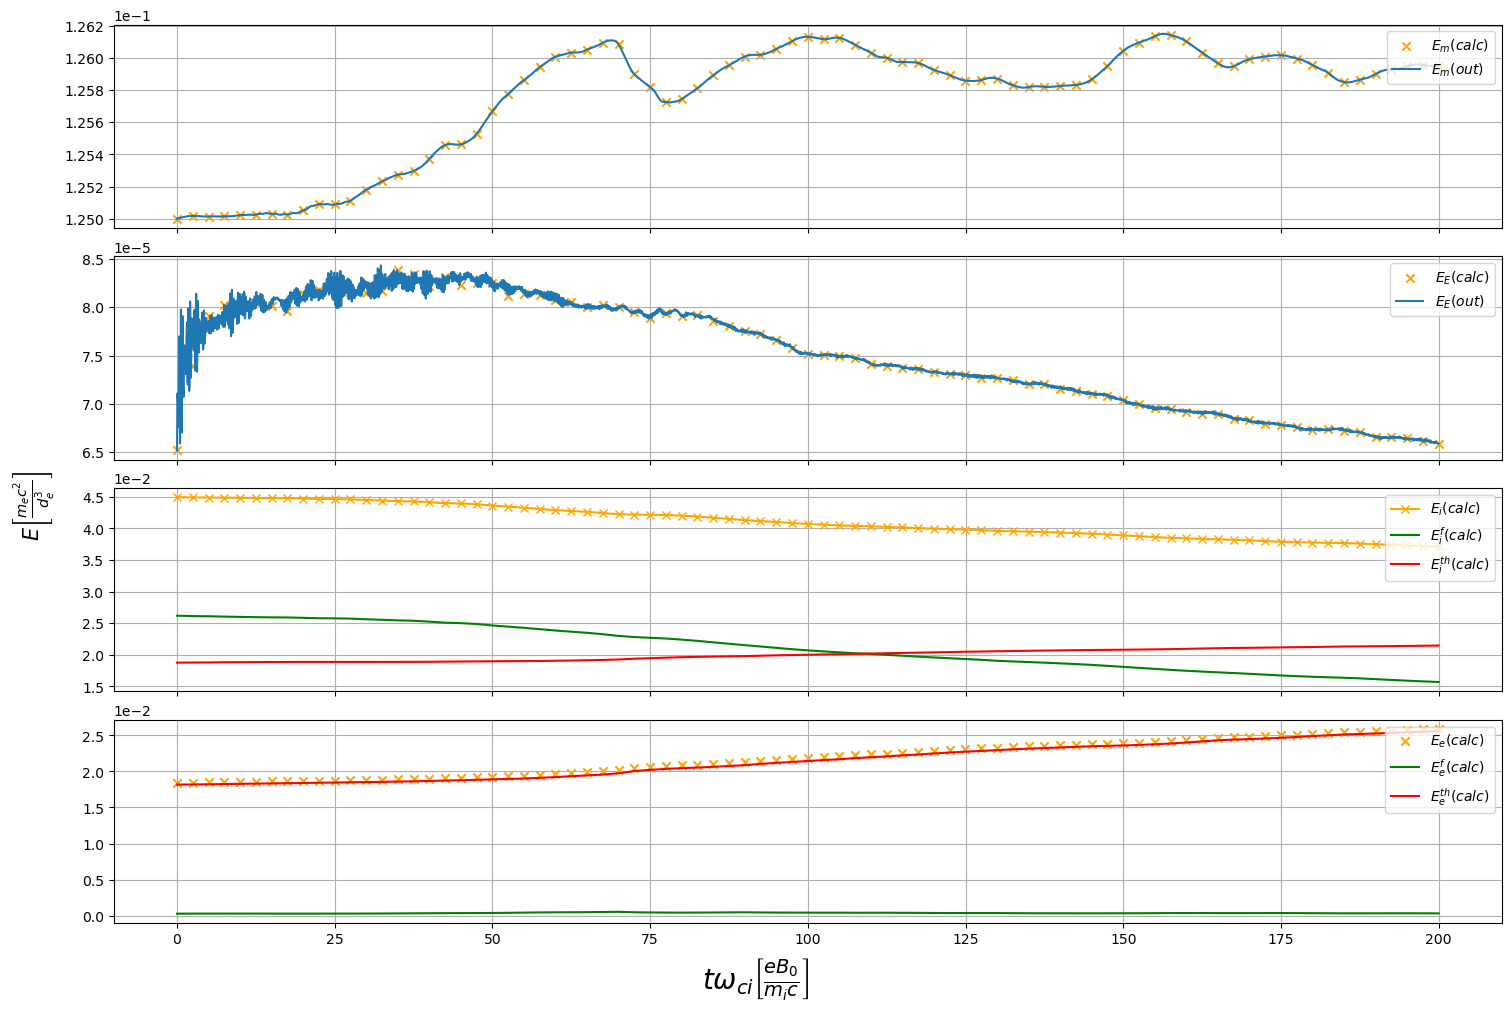

In [7]:
fig, axs = plt.subplots(4,1, figsize=(15, 10), sharex = True, layout='constrained')
axs[0].scatter(twci, en['EM'], color = 'orange', marker = 'x', label = r'$E_m (calc)$')
axs[0].plot(twci_out, en_out['EM'] , label = r'$E_m (out)$')

axs[1].scatter(twci, en['EE'], color = 'orange', marker = 'x', label = r'$E_E (calc)$')
axs[1].plot(twci_out, en_out['EE'], label = r'$E_E (out)$')

axs[2].plot(twci, en['Ethi'] + en['Efi'], color = 'orange', marker = 'x' , label = r'$E_i (calc)$')
axs[2].plot(twci, en['Efi'], color = 'green' , label = r'$E^{f}_i (calc)$')
axs[2].plot(twci, en['Ethi'], color = 'red' , label = r'$E^{th}_i (calc)$')
# axs[2].plot(twci_out, en_out['Ei'],label = r'$E_i (out)$')

axs[3].scatter(twci, (en['Ethe'] + en['Efe']), color = 'orange', marker = 'x', label = r'$E_e (calc)$')
axs[3].plot(twci, en['Efe'], color = 'green', label = r'$E^{f}_e (calc)$')
axs[3].plot(twci, en['Ethe'], color = 'red' , label = r'$E^{th}_e (calc)$')
# axs[3].plot(twci_out, en_out['Ee'],label = r'$E_i (out)$')


axs[0].legend(loc = 'upper right')
axs[1].legend(loc = 'upper right')
axs[2].legend(loc = 'upper right')
axs[3].legend(loc = 'upper right')

axs[0].grid()
axs[1].grid()
axs[2].grid()
axs[3].grid()

axs[0].ticklabel_format(axis = 'y',style = 'sci', scilimits = (0,0))
axs[1].ticklabel_format(axis = 'y',style = 'sci', scilimits = (0,0))
axs[2].ticklabel_format(axis = 'y',style = 'sci', scilimits = (0,0))
axs[3].ticklabel_format(axis = 'y',style = 'sci', scilimits = (0,0))

fig.supylabel(r'$E \left[ \frac{m_e c^2}{d_e^3} \right] $', size = 15)
fig.supxlabel(r'$ t \omega_{ci} \left[ \frac{e B_0}{m_i c} \right]$', size = 20)

plt.savefig(figs + 'en_comp_calc.jpg', dpi = 400)

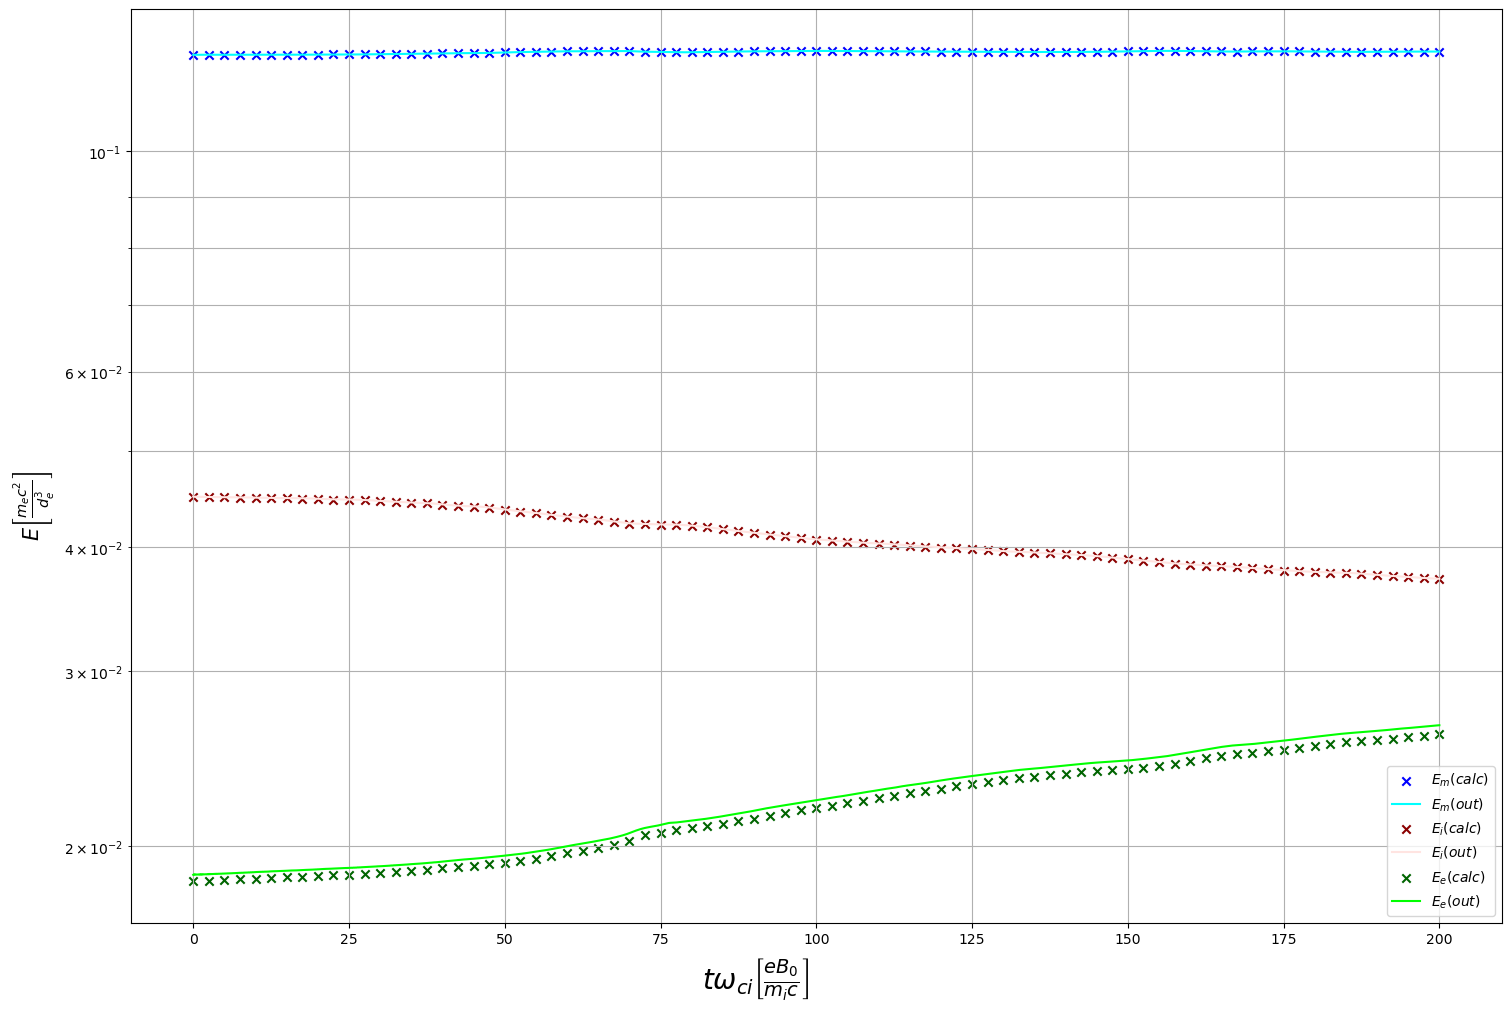

In [6]:
fig, axs = plt.subplots(1,1, figsize=(15, 10), sharex = True, layout='constrained')
axs.scatter(twci, en['EM'] + en['EE'], color = 'blue', marker = 'x', label = r'$E_m (calc)$')
axs.plot(twci_out, en_out['EM'] + en_out['EE'] , color = 'aqua', label = r'$E_m (out)$')

axs.scatter(twci, en['Ethi'] + en['Efi'], color = 'darkred', marker = 'x' , label = r'$E_i (calc)$')
# axs.plot(twci, en['Efi'], color = 'fuchsia' , label = r'$E^{f}_i (calc)$')
# axs.plot(twci, en['Ethi'], color = 'indigo' , label = r'$E^{th}_i (calc)$')
axs.plot(twci_out, en_out['Ei'], color = 'mistyrose',label = r'$E_i (out)$')

axs.scatter(twci, (en['Ethe'] + en['Efe']), color = 'darkgreen', marker = 'x', label = r'$E_e (calc)$')
# axs.plot(twci, en['Efe'], color = 'orange', label = r'$E^{f}_e (calc)$')
# axs.plot(twci, en['Ethe'], color = 'darkorange' , label = r'$E^{th}_e (calc)$')
axs.plot(twci_out, en_out['Ee'], color = 'lime', label = r'$E_e (out)$')

axs.set_yscale('log')
axs.legend()

axs.grid(which = 'both')


# axs.ticklabel_format(axis = 'y',style = 'sci', scilimits = (0,0))


fig.supylabel(r'$E \left[ \frac{m_e c^2}{d_e^3} \right] $', size = 15)
fig.supxlabel(r'$ t \omega_{ci} \left[ \frac{e B_0}{m_i c} \right]$', size = 20)

plt.savefig(figs + 'enout_calc.jpg', dpi = 400)